In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import numpy as np
from skimage.feature import hog
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd
import numpy as np


In [ ]:
from skimage import color
from skimage.feature import hog
# Extract HOG features
def extract_HOG_features(img):
    gray_image = color.rgb2gray(img)
    feature = hog(gray_image, orientations=9, pixels_per_cell=(32, 32), cells_per_block=(2, 2))
    return feature


#image = Image.open("dataset/train/10.png")
#image = image.resize((224, 224))


<class 'numpy.ndarray'>
8100


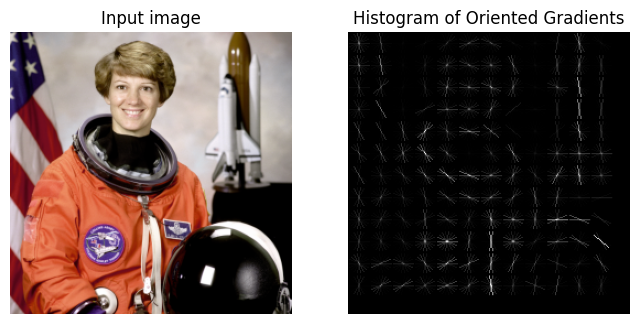

In [3]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
from skimage import color
from skimage.transform import resize

image = data.astronaut()
image = resize(image, (256, 256))
print(type(image))

gray_img = color.rgb2gray(image)

fd, hog_image = hog(
    gray_img,
    orientations=9,
    pixels_per_cell=(20, 20),
    cells_per_block=(3, 3),
    visualize=True,
)

print(len(fd))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis("off")
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title("Input image")

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis("off")
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title("Histogram of Oriented Gradients")
plt.show()


In [ ]:
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [ ]:
import glob
from torchvision.datasets import ImageFolder

image_dim = 256

resize_transform = [
    transforms.Resize((image_dim, image_dim)),
]
common_transform = [
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
train_compose = transforms.Compose(resize_transform + common_transform)
test_compose = transforms.Compose(resize_transform + common_transform)
tensor_transform = transforms.Compose([transforms.ToTensor()])


class WheelchairDataset(ImageFolder):
    def __init__(self, ground_truth_csv, root, transform=None):
        self.ground_truth = pd.read_csv(ground_truth_csv)
        self.root = root
        self.img_paths = glob.glob(self.root + "*.png")
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        feature = extract_HOG_features(image)
        image = tensor_transform(image)
        return image, feature


In [ ]:
import torchvision

dataset_path = "drive/MyDrive/Thesis/CIFAR_HOG/dataset/"
ground_truth_train = "train.csv"
ground_truth_test = "test.csv"

# train_dataset = WheelchairDataset(
#     ground_truth_csv=ground_truth_train,
#     root=dataset_path + "train/",
#     transform=train_compose,
# )
# test_dataset = WheelchairDataset(
#     ground_truth_csv=ground_truth_test,
#     root=dataset_path + "test/",
#     transform=train_compose,
# )


def imshow(img):
    npimg = img if type(img) == np.ndarray else img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


class CustomizedCIFAR10(torchvision.datasets.CIFAR10):
    def __init__(self, root, train, download, transform):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, idx):
        image, _ = super().__getitem__(idx)
        target = extract_HOG_features(np.transpose(image.numpy(), (1, 2, 0)))
        return image, target


train_dataset = CustomizedCIFAR10(
    root="drive/MyDrive/Thesis/CIFAR_HOG/data", train=True, download=True, transform=train_compose
)
test_dataset = CustomizedCIFAR10(
    root="drive/MyDrive/Thesis/CIFAR_HOG/data", train=False, download=True, transform=test_compose
)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True
)


In [ ]:
import torch.nn as nn

class HogNet(nn.Module):
    def __init__(self, len_hog_vector):
        super(HogNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(30 * 30 * 32, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.hog_vector = nn.Linear(4096, len_hog_vector)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = self.pool3(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.hog_vector(x)
        return x

len_hog_vector = 1764
# cnn = AlexSimplifiedNet()
# cnn.apply(init_weights)
cnn = HogNet(len_hog_vector)
cnn


HogNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28800, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (hog_vector): Linear(in_features=4096, out_features=1764, bias=True)
)

In [ ]:
# loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)


In [ ]:
losses = []
# Loss =  0.0056  test loss = 0.0058
# Loss =  0.0041  test loss = 0.0042
# Loss =  0.0037  test loss = 0.0038
cnn.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_3Conv3Pool_1764_v3.pth"))
old_val_loss = 100 # big number
for epoch in range(num_epochs):
    cnn.train()
    total_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        images = Variable(images.float())
        targets = Variable(targets.float())

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(
                "Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f"
                % (
                    epoch + 1,
                    num_epochs,
                    i + 1,
                    len(train_dataset) // batch_size,
                    total_loss / (i + 1),
                )
            )

    print("Total Training loss: ")
    print(total_loss * batch_size / len(train_dataset))
    # Comapare with last loss
    cnn.eval()
    val_loss = 0.0
    with torch.no_grad():
      for images, targets in test_loader:
          images = Variable(images.float())
          targets = Variable(targets.float())
          outputs = cnn(images)
          val_loss += criterion(targets, outputs).item()
    print(
        "Test loss of the model on the %d test images: %.4f"
        % (len(test_dataset), val_loss * batch_size / len(test_dataset))
    )
    if old_val_loss > val_loss:
        torch.save(cnn.state_dict(), "/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_3Conv3Pool_1764_v4.pth")
        old_val_loss = val_loss

Epoch : 1/10, Iter : 100/500,  Loss: 0.0054
Epoch : 1/10, Iter : 200/500,  Loss: 0.0045
Epoch : 1/10, Iter : 300/500,  Loss: 0.0042
Epoch : 1/10, Iter : 400/500,  Loss: 0.0041
Epoch : 1/10, Iter : 500/500,  Loss: 0.0040
Total Training loss: 
0.00400295848492533
Test loss of the model on the 10000 test images: 0.0038
Epoch : 2/10, Iter : 100/500,  Loss: 0.0036
Epoch : 2/10, Iter : 200/500,  Loss: 0.0036
Epoch : 2/10, Iter : 300/500,  Loss: 0.0036
Epoch : 2/10, Iter : 400/500,  Loss: 0.0036
Epoch : 2/10, Iter : 500/500,  Loss: 0.0036
Total Training loss: 
0.003604217899497598
Test loss of the model on the 10000 test images: 0.0038
Epoch : 3/10, Iter : 100/500,  Loss: 0.0036
Epoch : 3/10, Iter : 200/500,  Loss: 0.0036
Epoch : 3/10, Iter : 300/500,  Loss: 0.0036
Epoch : 3/10, Iter : 400/500,  Loss: 0.0036
Epoch : 3/10, Iter : 500/500,  Loss: 0.0036
Total Training loss: 
0.003595905295573175
Test loss of the model on the 10000 test images: 0.0038
Epoch : 4/10, Iter : 100/500,  Loss: 0.0036


<Figure size 640x480 with 0 Axes>

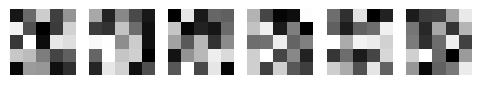

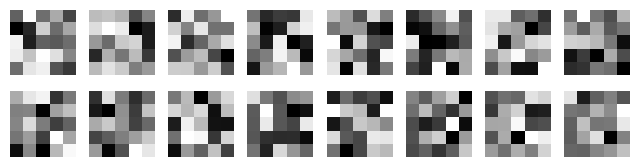

In [ ]:
def plot_kernels(tensor, num_cols=6, img_path=None):
    num_kernels = tensor.shape[0]
    num_rows = 1 + num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)
        ax1.imshow(tensor[i][0, :, :], cmap="gray")
        ax1.axis("off")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    if img_path:
        plt.savefig(img_path)


plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
filters = cnn.modules()
model_layers = [i for i in cnn.children()]
first_layer = model_layers[0]
second_layer = model_layers[2]
first_kernels = first_layer.weight.data.numpy()
plot_kernels(first_kernels, 8, 'plot_1.png')
second_kernels = second_layer.weight.data.numpy()
plot_kernels(second_kernels, 8, 'plot_2.png')


In [ ]:

cnn.eval()
image = data.astronaut()

image = Image.fromarray(image).resize((256, 256))
hog_gt = extract_HOG_features(image)
hog_pred = cnn(tensor_transform(image).view(1,3,224,224))

print(hog_gt)
print(hog_pred)

image2 = data.chelsea()
image = Image.fromarray(image2).resize((256, 256))
hog_gt = extract_HOG_features(image)
hog_pred = cnn(tensor_transform(image).view(1,3,224,224))

print(hog_gt)
print(hog_pred)

NameError: name 'cnn' is not defined

In [ ]:
import torch
from skimage import data
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

tensor_transform = transforms.Compose([transforms.ToTensor()])

cnn.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_3Conv3Pool_1764.pth"))
print(cnn)
cnn.eval()

image = data.astronaut()

image = Image.fromarray(image).resize((256, 256))
hog_gt = extract_HOG_features(image)
hog_pred = cnn(tensor_transform(image).view(1,3,256,256))

print(hog_gt)
print(hog_pred)

d = euclidean_distances(hog_gt.reshape(1, 1764), hog_pred.detach().numpy())[0][0]
print(d)

image2 = data.chelsea()
image = Image.fromarray(image2).resize((256, 256))
hog_gt2 = extract_HOG_features(image)
hog_pred2 = cnn(tensor_transform(image).view(1,3,256,256))

print(hog_gt2)
print(hog_pred2)
d = euclidean_distances(hog_gt2.reshape(1, 1764), hog_pred2.detach().numpy())[0][0]
print(d)

d = euclidean_distances(hog_pred.detach().numpy(), hog_pred2.detach().numpy())[0][0]
print(d)

HogNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28800, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (hog_vector): Linear(in_features=4096, out_features=1764, bias=True)
)
[0.30591587 0.30591587 0.13447946 ... 0.15029851 0.33696334 0.34396901]
tensor([[0.4085, 0.1531, 0.1081,  ..., 0.0237, 0.1264, 0.3074]],
       grad_fn=<AddmmBackward0>)
5.621785678671946
[0.23644243 0.09623852 0.07407664 ... 0.11581055 0.06186487 0.13019035]
tensor([[0.2379, 0.1150, 0.0664,  ..., 0.083

In [ ]:
import torch
import torch.nn as nn
from skimage import data
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

class PartialNet(nn.Module):
    def __init__(self, len_hog_vector):
        super(PartialNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        #self.conv3 = nn.Conv2d(32, 32, 3)
        #self.pool3 = nn.MaxPool2d(2, 2)
        #self.flatten = nn.Flatten()
        #self.fc1 = nn.Linear(26 * 26 * 32, 4096)
        #self.fc2 = nn.Linear(4096, 4096)
        #self.hog_vector = nn.Linear(4096, len_hog_vector)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        #x = self.pool3(nn.functional.relu(self.conv3(x)))
        #x = self.flatten(x) # flatten all dimensions except batch
        #x = nn.functional.relu(self.fc1(x))
        #x = nn.functional.relu(self.fc2(x))
        #x = self.hog_vector(x)
        return x
'''
class Pool2Hook(object):
  def __init__(self, layer):
    self.layer = layer
    self.output = None

  def __call__(self, module, input, output):
    self.output = output
'''
partial_model = PartialNet(441)

print(partial_model)
partial_model.load_state_dict(torch.load("/content/drive/MyDrive/Thesis/CIFAR_HOG/hog_3Conv3Pool_441_v2.pth"), strict=False)
partial_model.eval()

#specific_layer = partial_model.pool2  # Replace with your desired layer name
#hook = Pool2Hook(specific_layer)
#specific_layer.register_forward_hook(hook)

image = data.astronaut()
image = Image.fromarray(image).resize((224, 224))

tensor_transform = transforms.Compose([transforms.ToTensor()])
hog_pred = partial_model(tensor_transform(image).view(1,3,224,224))
#hog_pred = hook.output
hog_pred = torch.flatten(hog_pred, 1)
print(hog_pred.detach().numpy())
print(len(hog_pred[0]))

image = data.chelsea()
image = Image.fromarray(image).resize((224, 224))

tensor_transform = transforms.Compose([transforms.ToTensor()])
hog_pred = partial_model(tensor_transform(image).view(1,3,224,224))
#hog_pred = hook.output
hog_pred = torch.flatten(hog_pred, 1)
print(hog_pred.detach().numpy())
print(len(hog_pred[0]))

PartialNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
[[0.         0.04690785 0.09331098 ... 0.08578365 0.18658756 0.15359598]]
93312
[[0.         0.00625024 0.00499905 ... 0.06488486 0.05539398 0.04980272]]
93312
